In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Aprendizaje II

> Autor: Jorge García González (Universidad de Málaga)

> Última Actualización: 18/09/2025

> Asignatura: Programación para la Inteligencia Artificial

En la sesión anterior hemos visto cómo realizar un proceso de ajuste de parámetros iterativo en base a calcular las diferencias entre aumentar *ligeramente* y disminuir *ligeramente* el parámetro que queremos ajustar. Esa diferencia respecto al hiperparámetro la llamamos Δ y, aunque el proceso funciona, el hiperparámetro Δ resulta problemático. ¿Qué elegimos? ¿Uno muy pequeño? ¿Uno muy grande? Grande o pequeño son términos muy relativos. ¿En qué rango de valores estamos trabajando? ¿Cómo desciende la función?

Seguiremos trabajando con el ajuste de una recta así que vamos a rescatar algunas funciones de la sesión anterior:

In [2]:
def get_data_from_a_line(m, b, n, sigma=2, range=50):
  """
  Función que devuelve datos a partir de una recta. Recordemos que la ecuación de la recta está definida por y=mx+b.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    n: número de datos que queremos obtener.
    sigma: desviación típica para el ruido que añadiremos a los datos (2 por defecto).
    range: extremo del rango [0,rango] en el eje x en el que queremos situar los datos (50 por defecto).
  """
  x = range*torch.rand(n)                                               # Generamos los datos en el eje x.
  y = m*x+b                                                             # Obtemeos la posición correspondiente en el eje y.
  noise_x = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje x.
  noise_y = torch.normal(torch.zeros_like(y), sigma*torch.ones_like(y)) # Generamos un vector de ruido gaussiano para el eje y.
  x_with_noise = x + noise_x
  y_with_noise = y + noise_y

  data = torch.cat((x_with_noise[:,None], y_with_noise[:,None]), dim=1)
  return data

def line_model(m, b, inputs):
  """
  Functión para modelar una recta.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    inputs: vector con los valores de entrada para ser calculados por el modelo.
  """
  return m*inputs+b

def AE_loss(y_pred, y_true):
  return torch.abs(y_pred - y_true)

def SE_loss(y_pred, y_true):
  return (y_pred-y_true)**2

def MAE_loss(y_pred, y_true):
  """
  Función para calcular la media del error absoluto.
  """
  absolute_error = torch.abs(y_pred-y_true)
  return absolute_error.mean()

def MSE_loss(y_pred, y_true):
  """
  Función para calcular la media del error cuadrático.
  """
  squared_error = (y_pred-y_true)**2
  return squared_error.mean()

En la sesión anterior observamos cómo cambiaba el error para un punto dado según cómo se alteraba la inclinación de la recta. Vamos ahora a ver cómo evoluciona alterando los dos parámetros (m y b).

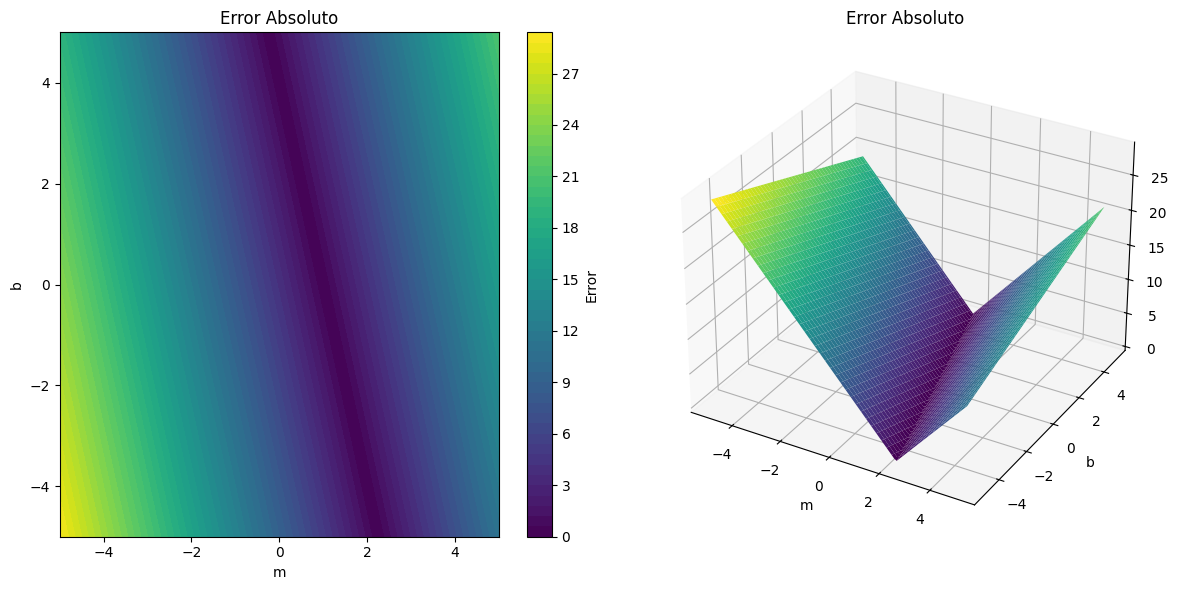

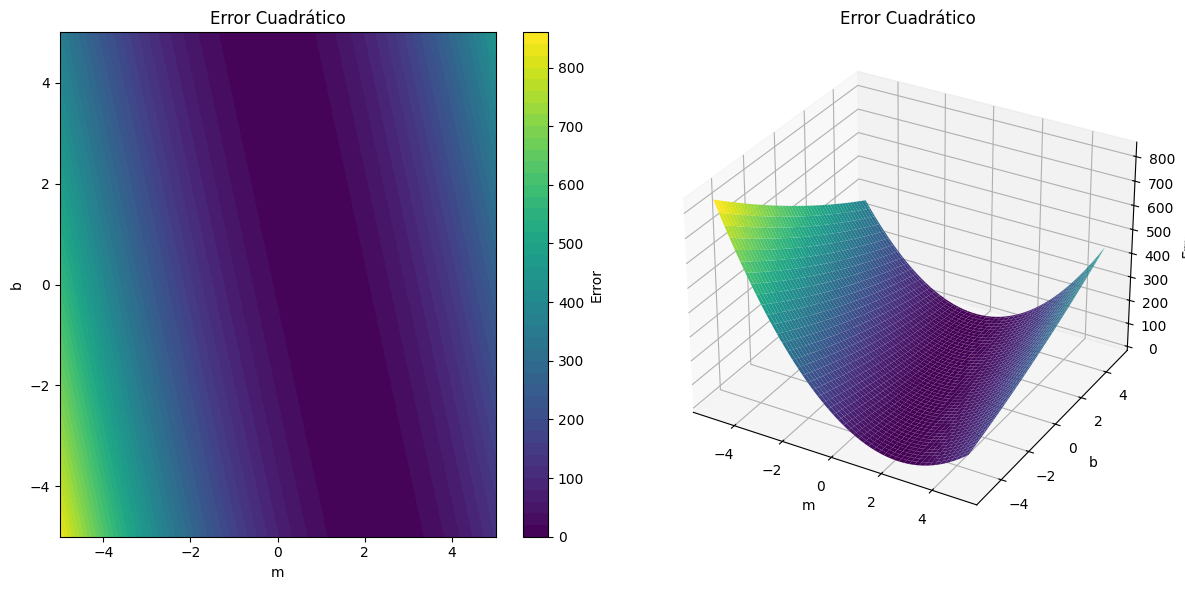

In [3]:
x_true, y_true = (4,4)
ae_list = []
se_list = []

m = torch.linspace(-5,5,100)
b = torch.linspace(-5,5,100)
M, B = torch.meshgrid(m, b, indexing='ij')   # Producto cartesiano
y_pred = line_model(M,B,x_true)
ae_error = AE_loss(y_pred, y_true)
se_error = SE_loss(y_pred, y_true)

# Mostramos el Error Absoluto
fig = plt.figure(figsize=(12, 6))

# Plotear un mapa de calor
ax1 = fig.add_subplot(1, 2, 1)
c = ax1.contourf(M, B, ae_error, levels=50, cmap="viridis")
fig.colorbar(c, ax=ax1, label="Error")
ax1.set_xlabel("m")
ax1.set_ylabel("b")
ax1.set_title("Error Absoluto")

# Superficie 3D
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(M, B, ae_error, cmap="viridis")
ax2.set_xlabel("m")
ax2.set_ylabel("b")
ax2.set_zlabel("Error")
ax2.set_title("Error Absoluto")

plt.tight_layout()
plt.show()

# Mostramos el Error Cuadrático
fig = plt.figure(figsize=(12, 6))

# Plotear un mapa de calor
ax1 = fig.add_subplot(1, 2, 1)
c = ax1.contourf(M, B, se_error, levels=50, cmap="viridis")
fig.colorbar(c, ax=ax1, label="Error")
ax1.set_xlabel("m")
ax1.set_ylabel("b")
ax1.set_title("Error Cuadrático")

# Superficie 3D
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
ax2.plot_surface(M, B, se_error, cmap="viridis")
ax2.set_xlabel("m")
ax2.set_ylabel("b")
ax2.set_zlabel("Error")
ax2.set_title("Error Cuadrático")

plt.tight_layout()
plt.show()

Como podemos observar, cada parámetro aumenta o disminuye el error "a una velocidad distinta". Un cambio en el parámetro m altera el error más que un cambio en el parámetro b. Si el hiperparámetro Δ determina cuánto alteramos un parámetro para obtener el ratio de cambio, el mismo valor para dos parámetros que hacen cambiar la función a ritmos distintos es problemático. Un buen valor de Δ para un parámetro podría ser uno malo para el otro. ¿Qué hacemos? ¿Elegimos un Δ para cada parámetro? Si tenemos mil parámetros, ¿elegimos mil valores? No parece muy práctico. Mejor eliminar ese hiperparámetro :)

Y para eliminarlo vamos a usar el gradiente (representado con ∇) de la función de error. Intuitivamente podemos entender el vector gradiente de una función calculado en un punto como la dirección en la que la función varía más rápidamente y su módulo representa el ritmo de variación en dicha dirección.

Más información: https://es.wikipedia.org/wiki/Gradiente

Justo lo que necesitamos. Usábamos el hierparámetro Δ para hacer un cálculo que indique hacia dónde alterar el parámetro. El gradiente es otra manera de obtener esa información. ¡Necesitamos calcular el gradiente del error en un punto concreto!

¿Cómo se calcula el gradiente? Obteniendo las derivadas parciales. Concretamente necesitaremos derivar funciones compuestas ya que el error se calcula a partir del modelo, así que vamos a repasar cómo se deriva una función compuesta.

Recordemos la Regla de la Cadena (o Teorema de las Funciones Compuestas, que suena mucho mejor). Esta regla dice que la derivada de una función compuesta h(x) = f(g(x)) se calcula como:

h(x)dx = (f(g(x))dx)(g(x)dx).

Más información: https://es.wikipedia.org/wiki/Regla_de_la_cadena

La regla de la cadena es clave en todo lo que vamos a hacer. En nuestro caso tenemos la función de error (que vamos a llamar 𝘓) que depende de la función que representa nuestro modelo de recta (que vamos a llamar r<sub>m,b</sub> indicando que es una función que depende de los parámetros m y b). Dado un dato conocido (xₙ,yₙ) y unos parámetros m y b, el error es 𝘓(r<sub>m,b</sub>(xₙ), yₙ). Para obtener el gradiente de los parámetros debemos obtener las derivadas parciales respecto a cada uno de esos parámetros.

∇<sub>m,b</sub>𝐿 = (∂𝐿/∂m,∂𝐿/∂b)

Y aplicando la regla de la cadena:

(∂𝐿/∂m,∂𝐿/∂b) = ((∂𝐿/∂r<sub>m,b</sub>)(∂r<sub>m,b</sub>/∂m),(∂𝐿/∂r<sub>m,b</sub>)(∂r<sub>m,b</sub>/∂b))

En definitiva, debemos obtener la derivada de la función de coste  respecto al modelo (∂𝐿/∂r<sub>m,b</sub>) y las derivadas parciales de nuestro modelo (∂r<sub>m,b</sub>/∂m y ∂r<sub>m,b</sub>/∂b).

Vamos a empezar por las derivadas de nuestras funciones de error. Estamos trabajando con errores medios. Para "derivar" la media no hay más que entenderla como una sucesión de sumas multiplicada por una constante (1/N con N el número de elementos en la suma). La derivada de la suma es la suma de las derivadas y la derivada de una constante por una función es la constante por la derivada de la función. Vamos, que derivar una media es hacer la media de las derivadas. Para que quede más claro, vamos a implementar la derivada de la función para cada elemento y luego aplicaremos la media.

En el caso del error cuadrático, la derivada es sencilla: x<sup>2</sup>dx = 2x.

El error absoluto medio es también sencillo, pero tiene un problema: no es derivable en todo el dominio. El valor absoluto es una función definida a trozos (f(x)=x si x>=0, f(x)=-x si x<0). Una función definida a trozos solo es derivable si coinciden las derivadas laterales en los puntos de transición. En este caso no coinciden. La función no es derivable en el 0.

Sin embargo... nos da igual. Es un problema menor ya que en cada trozo la derivada tiene un valor constante (-1 si x<0, 1 si x>0). Podemos decidir arbitrariamente si en el 0 devolver un valor -1 o un valor 1 simplemente para evitar un problema numérico. ¿Tiene esto mucha justificación matemática? No, pero cumple su función. Más problemático sería si la no derivabilidad fuera consecuencia de una indeterminación.

Nota: En esta implementación veréis que no he hecho la media de las derivadas, sino que devuelvo la derivada para todos los puntos. La media la hago más adelante :)

In [4]:
def AE_loss_d_y_pred(y_pred, y_true):
  """
  Derivada del error absoluto.
  """
  absolute_error_d_y_pred = ((y_pred-y_true)>=0)*1+((y_pred-y_true)<0)*-1
  return absolute_error_d_y_pred

def SE_loss_d_y_pred(y_pred, y_true):
  """
  Derivada del error cuadrático.
  """
  squared_error_d_y_pred = 2*(y_pred-y_true)
  return squared_error_d_y_pred

Una vez tenemos la derivada de las funciones de error, ahora necesitamos las derivadas parciales del modelo. Las parciales de y=mx+b respecto a los parámetros m y b son triviales.

In [5]:
def line_model_d_m(m, b, inputs):
  """
  Derivada respecto a la m de la functión para modelar una recta.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    inputs: vector con los valores de entrada para ser calculados por el modelo.
  """
  return inputs

def line_model_d_b(m,b,inputs):
  """
  Derivada respecto a la b de la functión para modelar una recta.
  Args:
    m: inclinación de la recta.
    b: ordenada en el origen de la recta.
    inputs: vector con los valores de entrada para ser calculados por el modelo.
  """
  return 1.0


Finalmente componemos una función gradiente para cada función de error usando la regla de la cadena.

Nota: Hago la media correspondiente a la derivada de la media de los errores ahora. ¿Por qué? Porque así multiplicamos elemento a elemento la derivada de la función de error con la parcial del modelo. Estamos, por tanto, haciendo el cálculo del gradiente para cada punto y luego hacemos la media. Teóricamente debería ser lo mismo.

In [6]:
def grad_MAE(x_true, y_pred, y_true, m, b):
  ae_loss_d_y_pred = AE_loss_d_y_pred(y_pred, y_true)
  ae_loss_d_m = ae_loss_d_y_pred * line_model_d_m(m,b, x_true)
  ae_loss_d_b = ae_loss_d_y_pred * line_model_d_b(m,b, x_true)
  mae_loss_d_m = ae_loss_d_m.mean()
  mae_loss_d_b = ae_loss_d_b.mean()
  return torch.stack([mae_loss_d_m, mae_loss_d_b])

def grad_MSE(x_true, y_pred, y_true, m, b):
  se_loss_d_y_pred = SE_loss_d_y_pred(y_pred, y_true)
  se_loss_d_m = se_loss_d_y_pred * line_model_d_m(m,b, x_true)
  se_loss_d_b = se_loss_d_y_pred * line_model_d_b(m,b, x_true)
  mse_loss_d_m = se_loss_d_m.mean()
  mse_loss_d_b = se_loss_d_b.mean()
  return torch.stack([mse_loss_d_m, mse_loss_d_b])

Vamos a ver cómo queda nuestro nuevo algoritmo de ajuste de parámetros. Aunque hemos hecho las funciones para ajustar los dos parámetros (m,b), vamos a seguir suponiendo que la b queda constante por una cuestión meramente didactica (así solo hay un mínimo :P).

--------- step 0
m,b actual: (0.8, 0)
Valor medio de y: 11.028847694396973
Valor medio de y predicho: 17.50367546081543
Gradiente: tensor([21.2875,  0.8000]), actualización de m: -0.02128753252327442
--------- step 1
m,b actual: (tensor(0.7787), 0)
Valor medio de y: 11.028847694396973
Valor medio de y predicho: 17.03791046142578
Gradiente: tensor([21.2875,  0.8000]), actualización de m: -0.02128753252327442
--------- step 2
m,b actual: (tensor(0.7574), 0)
Valor medio de y: 11.028847694396973
Valor medio de y predicho: 16.572147369384766
Gradiente: tensor([20.6775,  0.7600]), actualización de m: -0.02067747339606285
--------- step 3
m,b actual: (tensor(0.7367), 0)
Valor medio de y: 11.028847694396973
Valor medio de y predicho: 16.119733810424805
Gradiente: tensor([20.6775,  0.7600]), actualización de m: -0.02067747339606285
--------- step 4
m,b actual: (tensor(0.7161), 0)
Valor medio de y: 11.028847694396973
Valor medio de y predicho: 15.667320251464844
Gradiente: tensor([20.6775,  0.76

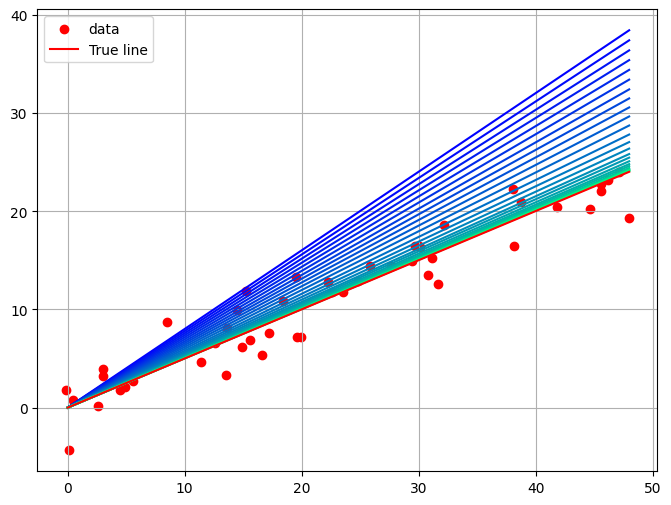

In [ ]:
learning_rate = 1e-3
delta = 0.1
steps = 25
loss_fn = MAE_loss
loss_fn_grad = grad_MAE

true_m, true_b = [0.5,0]
data = get_data_from_a_line(true_m, true_b, 50)
m = 0.8                                         # Inicializamos la m a 0.8 con propósitos meramente didácticos.
b = 0
line_evolution_m = [m]
line_evolution_b = [b]

for step in range(steps):
  x_true = data[:,0]
  y_true = data[:,1]
  y_pred = line_model(m, b, x_true)                   # Forward

  # hombrefrustrado -> este loss literalmente lo ha calculado para nada por que despues no lo usa, es una variable muerta
  loss = loss_fn(y_pred, y_true)
  grad = loss_fn_grad(x_true, y_pred, y_true, m, b)   # Backward
  print(f"--------- step {step}")
  print(f"m,b actual: {m,b}")
  print(f"Valor medio de y: {y_true.mean()}")
  print(f"Valor medio de y predicho: {y_pred.mean()}")
  print(f"Gradiente: {grad}, actualización de m: {-learning_rate*grad[0]}")
  m = m - learning_rate*grad[0]
  #b = b - learning_rate*grad[1]
  line_evolution_m.append(m)
  line_evolution_b.append(b)

plt.figure(figsize=(8,6))
colors = plt.cm.winter(torch.linspace(0,1,steps+1))
for index, (m, b) in enumerate(zip(line_evolution_m, line_evolution_b)):
  plt.plot([0,data[:,0].max()], [m*0+b,m*data[:,0].max()+b], c=colors[index])
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.plot([0,data[:,0].max()], [true_m*0+true_b,true_m*data[:,0].max()+true_b], c='r', label="True line")
plt.legend()
plt.grid(True)
plt.show()

Parece que funciona, pero hay algunas cosas llamativas. Para empezar, aunque no estamos actualizando la b y le hemos asignado desde el principio el valor que sabemos correcto, el gradiente indica que debe disminuir. Esto se puede deber a que los datos no ajustan perfectamente la recta (cosas de la generación estocástica de datos). A eso podemos achacar también que la recta ajustada esté ligeramente por debajo de la ideal. También se puede notar que ahora *restamos* a la hora de ajustar la variable. Esto se debe a que el gradiente conceptualmente nos da la dirección de incremento y nosotros queremos minimizar. ¡Δ ha muerto, larga vida a ∇!

Además hay dos líneas que hemos señalado como *forward* y *backward*. Por convención denominamos *forward* como el *paso hacia adelante* del modelo (realizar la predicción). Con *backward* nos referimos al *paso hacia atrás* (calcular los gradientes).

Entonces es de suponer que para trabajr en Aprendizaje Profundo habrá que pasarse el día definiendo derivadas. En este caso nuestro modelo solo tiene dos parámetros, pero un modelo con millones de parámetros requerirá definir millones de derivadas parciales ^^U

Por suerte, derivar es un proceso que consiste en seguir reglas. Se puede automatizar y de hecho... PyTorch lo tiene automatizado :)

La mayoría de las funciones integradas en PyTorch ya tienen programadas sus derivadas y PyTorch tiene un sistema denominado autograd para obtener automáticamente los gradientes de la composición de funciones si esas funciones se han hecho con PyTorch.

In [8]:
tensor_a = torch.tensor(2., requires_grad=True)
print(f"a: {tensor_a}")

tensor_b = tensor_a**3
print(f"b: {tensor_b}")

print(f"Gradiente de la función x**3 respecto al tensor_a: {tensor_a.grad}")

tensor_b.backward()
print(f"Gradiente de la función x**3 respecto al tensor_a: {tensor_a.grad}")

a: 2.0
b: 8.0
Gradiente de la función x**3 respecto al tensor_a: None
Gradiente de la función x**3 respecto al tensor_a: 12.0


En el ejemplo definimos un tensor con valor 2 y calculamos un segundo tensor elevando al cubo. Podemos indicarle a PyTorch que calcule el gradiente (realice el *backward* o paso hacia atrás) desde los resultados y si no se lo indicamos no lo realiza. Calcular los gradientes puede no ser un cálculo computacionalmente trivial, así que no lo hace por defecto.

Cuando operamos con un tensor cuyo gradiente se requiere, PyTorch lleva un registro de las operaciones en las que está implicado. Este registro es el grafo de operaciones, en el que los tensores cuyo gradiente se requiere deberían ser nodos hoja (interpretando que el grafo se extiende desde las últimas operaciones). Cuando llamamos a .backward() desde un nodo resultado de alguna operación, PyTorch recorre el grafo hacia atrás calculando las derivadas hasta los nodos hoja que requieren gradiente. Obtenemos así el resultado de la derivada parcial respecto a cada tensor hoja.

En el ejemplo de arriba el tensor hoja es a, la única operación es elevarlo al cubo y el resultao es b. Calcular el backward hacia atrás es solo calcular la derivada de x<sup>3</sup>. La derivada es 3x<sup>2</sup>, que para la entrada (2), tiene resultado 12. Ese es el valor del gradiente.

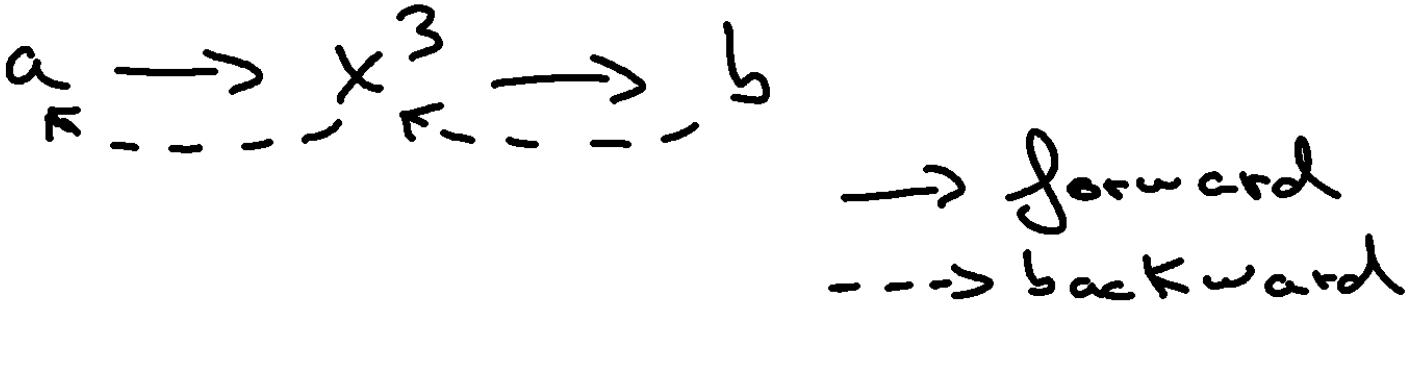

Por supuesto, funciones habituales de error como el error cuadrático medio o el error absoluto están ya implementadas en PyTorch (y precompiladas, así que serán más rápidas que una implementación nuestra).

Las podemos encontrar como L1Loss (error absoluto) y MSELoss (error cuadrático). ¿Por qué L1 en vez de MAE? Simplemente hace referencia a que matemáticamente se lo conoce como la norma L1. EL MSE a veces se denomina norma L2. PyTorch decidió mezclar nomenclaturas.

L1Loss: https://docs.pytorch.org/docs/stable/generated/torch.nn.L1Loss.html

MSELoss: https://docs.pytorch.org/docs/stable/generated/torch.nn.MSELoss.html

Así que podemos hacer de nuevo nuestro algoritmo de aprendizaje usando las funciones de PyTorch.

--------- step 0
m,b actual: (tensor(0.8000, requires_grad=True), tensor(0., requires_grad=True))
Valor medio de y: 12.966455459594727
Valor medio de y predicho: 20.797880172729492
Gradiente: [tensor(25.5839), tensor(0.8400)]
Actualización de m: -0.025583885610103607
--------- step 1
m,b actual: (tensor(0.7744, requires_grad=True), tensor(0., requires_grad=True))
Valor medio de y: 12.966455459594727
Valor medio de y predicho: 20.132770538330078
Gradiente: [tensor(25.5000), tensor(0.8000)]
Actualización de m: -0.025500046089291573
--------- step 2
m,b actual: (tensor(0.7489, requires_grad=True), tensor(0., requires_grad=True))
Valor medio de y: 12.966455459594727
Valor medio de y predicho: 19.469833374023438
Gradiente: [tensor(25.0930), tensor(0.7600)]
Actualización de m: -0.02509300410747528
--------- step 3
m,b actual: (tensor(0.7238, requires_grad=True), tensor(0., requires_grad=True))
Valor medio de y: 12.966455459594727
Valor medio de y predicho: 18.817481994628906
Gradiente: [tens

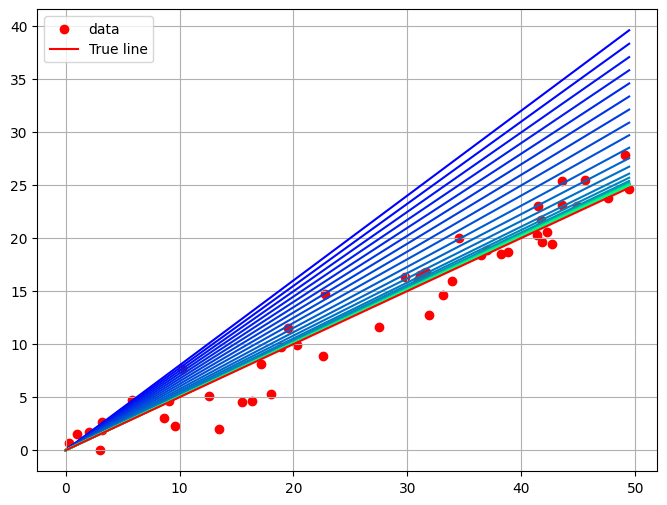

In [9]:
learning_rate = 1e-3
delta = 0.1
steps = 25
loss_fn = torch.nn.L1Loss()

true_m, true_b = [0.5,0]
data = get_data_from_a_line(true_m, true_b, 50)
m = torch.tensor(0.8, requires_grad=True)             # Inicializamos la m a 0.8 con propósitos meramente didácticos.
b = torch.tensor(0., requires_grad=True)
line_evolution_m = [m.clone().detach()]               # A las listas no añadimos el parámetro, sino una copia que nos aseguramos
line_evolution_b = [b.clone().detach()]               # de sacar del grafo usando un detach()

for step in range(steps):
  if m.grad is not None:
    m.grad.zero_()
  if b.grad is not None:
    b.grad.zero_()

  x_true = data[:,0]
  y_true = data[:,1]
  y_pred = line_model(m, b, x_true)                   # Forward
  loss = loss_fn(y_pred, y_true)
  loss.backward()                                     # Backward
  grad = [m.grad, b.grad]
  print(f"--------- step {step}")
  print(f"m,b actual: {m,b}")
  print(f"Valor medio de y: {y_true.mean()}")
  print(f"Valor medio de y predicho: {y_pred.mean()}")
  print(f"Gradiente: {grad}")
  print(f"Actualización de m: {-learning_rate*grad[0]}")
  with torch.no_grad():
    #m = m - learning_rate*grad[0]                        # No funciona
    #m = (m - learning_rate*grad[0]).requires_grad_(True) # Funciona, pero es un poco engorroso.
    m -= learning_rate*grad[0]                            # Funciona, es más "elegante" y más eficiente.
    #b -= learning_rate*grad[1]                          # Comentado para centrarnos en el parámetro m.
  line_evolution_m.append(m.clone().detach())
  line_evolution_b.append(b.clone().detach())

plt.figure(figsize=(8,6))
colors = plt.cm.winter(torch.linspace(0,1,steps+1))
for index, (m, b) in enumerate(zip(line_evolution_m, line_evolution_b)):
  plt.plot([0,data[:,0].max()], [m*0+b,m*data[:,0].max()+b], c=colors[index])
plt.scatter(data[:,0], data[:,1], marker='o', c='r', label="data")
plt.plot([0,data[:,0].max()], [true_m*0+true_b,true_m*data[:,0].max()+true_b], c='r', label="True line")
plt.legend()
plt.grid(True)
plt.show()

En este caso el grafo de operaciones es un poco más complicado, pero sería algo así (omitiendo variables intermedias y abstrayendo el cálculo de la L1):

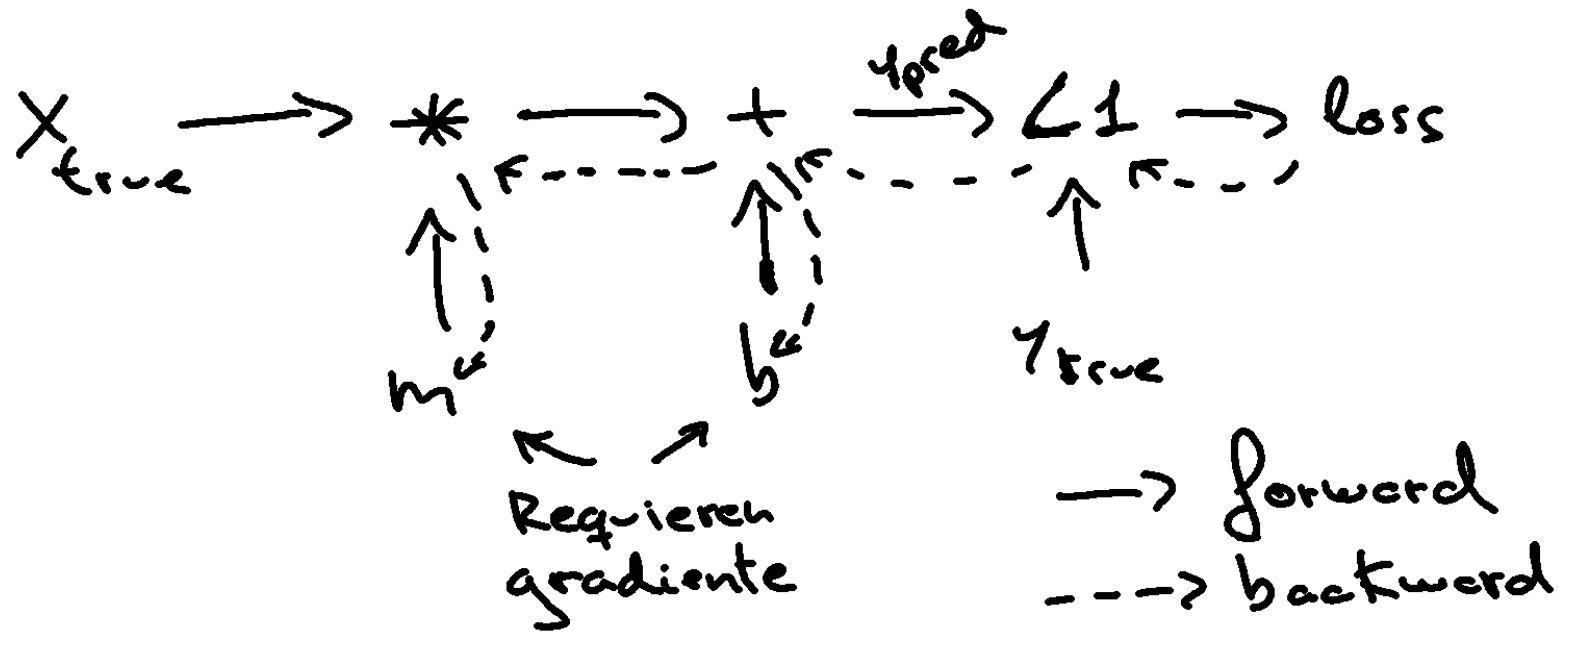

Hay varias cosas llamativas más allá de los cambios en la función de error, ¿verdad? Vamos a verlas una a una.

*   Para empezar, hemos necesitado indicarle a PyTorch que requeriremos el gradiente de los parámetros. Le estamos diciendo explícitamente que construya un grafo de computación con las operaciones que hagamos a partir de ellos.
*   Después podemos ver que al añadirlos a las listas estamos haciendo copias (.clone) y aplicamos un .detach a esa copia. El detach es una forma de indicarle a PyTorch que esa variable hay que sacarla del grafo de computación para obtener gradientes. Si no lo hacemos, dará un error matplotlib indicando que no puede trabajar con datos que requieren gradiente.
*   m.grad.zero_() es una manera de indicarle a PyTorch que devuelva el gradiente acumulado en ese tensor a 0. PyTorch funciona *acumulando* gradientes. Si calculamos varias veces el gradiente respecto a un parámetro lo *suma* al anterior y nosotros no queremos ese comportamiento.
*   Llamamos explícitamente al procedimiento .backward() de la función de error. ¡PyTorch se encarga de hacer el cálculo del gradiente respecto a los parámetros que lo requieren en ese momento!
* with torch.nograd es una manera de indicarle a PyTorch que el contexto encapsulado por el with no lo tenga en cuenta a la hora de crear el grafo de computación para calcular gradientes. ¡No nos interesa añadir la actualización de los parámetros al cálculo del gradiente!

También se pueden observar varias opciones para actualizar el parámetro m. La primera y más directa no funciona porque crea otro tensor m (con el mismo nombre, sí, pero otro tensor) que por defecto no requiere gradiente. Hacerlo así lleva a un error en la segunda época del bucle porque m no tiene gradiente. En la segunda opción forzamos que ese nuevo tensor requiera el gradiente para solucionarlo, pero es más simple hacer una operación que, en vez de generar un nuevo tensor, guarde la información en el antiguo. Ahorramos requerir más memoria y obtenemos el resultado deseado :)

Recapitulando:

*   Hemos visto que depender de un Δ para obtener la dirección de ajuste de los parámetros es problemático.
*   El gradiente nos permite obtener esa dirección de ajuste sin requerir \Delta.
*   Podemos crear nuestros medios para calcular el gradiente, pero no es práctico. ¡PyTorch se encarga!





